<a href="https://colab.research.google.com/github/rjrahul24/ai-with-python-series/blob/main/05.%20Build%20Concrete%20Time%20Series%20Forecasts/Colab%20Notebook/TimeSeries_Validation_ModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the basic preprocessing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# The series module from Pandas will help in creating a time series
from pandas import Series,DataFrame
import seaborn as sns
%matplotlib inline

# About the Data Set (Location: https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data) 
# To forecast the daily climate of a city in India
time_series = pd.read_csv('/content/DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col='date')
time_series.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a903edc50>,
      dtype=object)

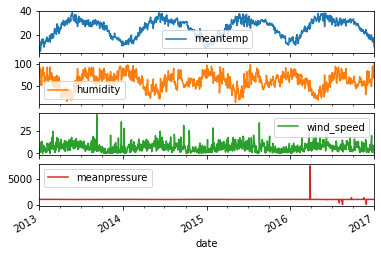

In [2]:
# Below are a few statistical methods on time series that will help in understanding the data patterns
# Plotting all the individual columns to observe the pattern of data in each column
time_series.plot(subplots=True)

In [3]:
# Calculating the mean, maximum values, and minimum of all individual columns of the dataset
time_series.mean()

meantemp          25.495521
humidity          60.771702
wind_speed         6.802209
meanpressure    1011.104548
dtype: float64

In [4]:
time_series.max()

meantemp          38.714286
humidity         100.000000
wind_speed        42.220000
meanpressure    7679.333333
dtype: float64

In [5]:
time_series.min()

meantemp         6.000000
humidity        13.428571
wind_speed       0.000000
meanpressure    -3.041667
dtype: float64

In [6]:
# The describe() method gives information like count, mean, deviations and quartiles of all columns
time_series.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


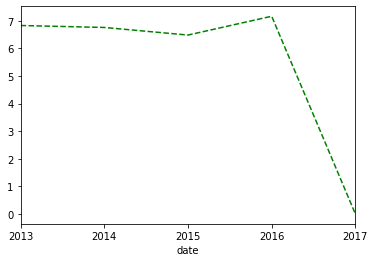

In [7]:
# Resampling the dataset using the Mean() resample method
timeseries_mm = time_series['wind_speed'].resample("A").mean()
timeseries_mm.plot(style='g--')
plt.show()

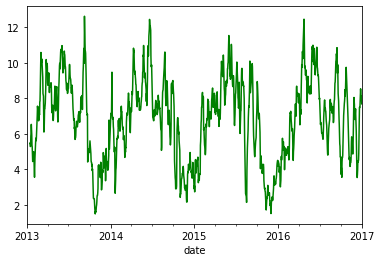

In [8]:
# Calculating the rolling mean with a 14-bracket window between time intervals
time_series['wind_speed'].rolling(window=14, center=False).mean().plot(style='-g')
plt.show()

In [9]:
# In the coming sections we will implement time series forecasting on the same dataset

In [10]:
# The series module from Pandas will help in creating a time series
from pandas import Series,DataFrame
%matplotlib inline
# Statsmodel and Adfuller will help in testing the stationarity of the time series
import statsmodels
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
time_series_train = pd.read_csv('/content/DailyDelhiClimateTrain.csv', parse_dates=True)
time_series_train["date"] = pd.to_datetime(time_series_train["date"])
time_series_train.date.freq ="D"
time_series_train.set_index("date", inplace=True)
time_series_train.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

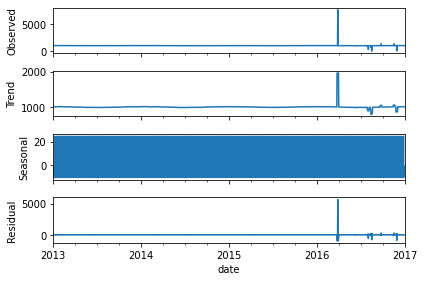

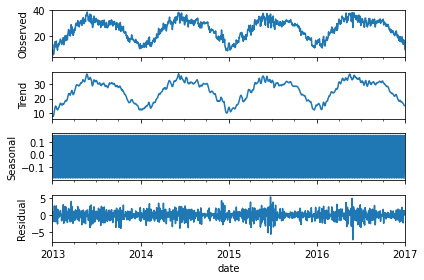

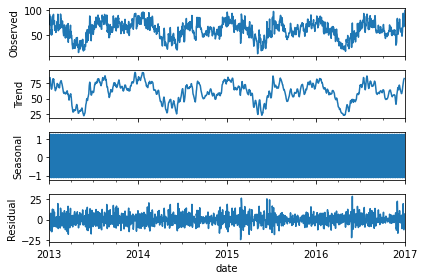

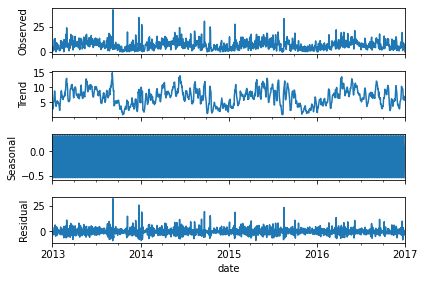

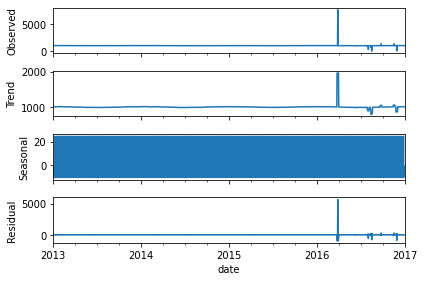

In [13]:
# Decomposing the time series with Statsmodels Decompose Method
from statsmodels.tsa.seasonal import seasonal_decompose
sd_1 = seasonal_decompose(time_series_train["meantemp"])
sd_2 = seasonal_decompose(time_series_train["humidity"])
sd_3 = seasonal_decompose(time_series_train["wind_speed"])
sd_4 = seasonal_decompose(time_series_train["meanpressure"])
sd_1.plot()
sd_2.plot()
sd_3.plot()
sd_4.plot()

In [15]:
# From the above graph’s observations, it looks like everything other than meanpressure is already stationary

# To re-confirm stationarity, we will run all columns through the ad-fuller test
adfuller(time_series_train["meantemp"])
adfuller(time_series_train["humidity"])
adfuller(time_series_train["wind_speed"])
adfuller(time_series_train["meanpressure"])

# Consolidate the ad-fuller tests to test from static data
temp_var = time_series_train.columns
print('significance level : 0.05')
for var in temp_var:
    ad_full = adfuller(time_series_train[var])
    print(f'For {var}')
    print(f'Test static {ad_full[1]}',end='\n \n')

significance level : 0.05
For meantemp
Test static 0.2774121372301611
 
For humidity
Test static 0.004470100478130758
 
For wind_speed
Test static 0.0025407221531464
 
For meanpressure
Test static 0.0
 


In [16]:
# With the ad-fuller test, we can now conclude that all data is stationary since static tests are below significance levels. This also rejects the hypothesis that meanpressure was non-static.

# Let us now move towards training and validating the prediction model
from statsmodels.tsa.vector_ar.var_model import VAR
train_model = VAR(time_series_train)
fit_model = train_model.fit(6)
# AIC is lower for lag_order 6. Hence, we can assume the lag_order of 6.
fix_train_test = time_series_train.dropna()
order_lag_a = fit_model.k_ar
X = fix_train_test[:-order_lag_a]
Y = fix_train_test[-order_lag_a:]

# Model Validation
validate_y = X.values[-order_lag_a:]
forcast_val = fit_model.forecast(validate_y,steps=order_lag_a)
train_forecast = DataFrame(forcast_val,index=time_series_train.index[-order_lag_a:],columns=Y.columns)
train_forecast

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-27,17.348792,70.642850,7.421823,1114.035254
2016-12-28,17.726869,68.599848,6.255075,1010.853957
2016-12-29,17.496228,70.909252,6.333213,992.402101
2016-12-30,17.648930,72.704921,5.795082,1004.788372
2016-12-31,17.642094,73.481324,5.946337,1031.434268
2017-01-01,17.884142,72.291600,5.717422,1026.203648


In [17]:
# Check performance of the predictions’ model
from sklearn.metrics import mean_absolute_error
for i in time_series_train.columns:
    print(f'MAE of {i} is {mean_absolute_error(Y[[i]],train_forecast[[i]])}')

MAE of meantemp is 2.882283181099115
MAE of humidity is 13.130988743453743
MAE of wind_speed is 1.9202180017101245
MAE of meanpressure is 27.450580288020337


In [18]:
# Humidity and Meanpressure are showing higher errors of forecast. We could assume that certain external factors are causing this.
# This model, therefore, forecasts wind speed and mean temperature accurately with less than 5% error
# Let us now implement this on the test data and forecast for the next 6 future periods of time

test_forecast = pd.read_csv('DailyDelhiClimateTest.csv',parse_dates=['date'], index_col='date')
period_range = pd.date_range('2017-01-05',periods=6)
order_lag_b = fit_model.k_ar
X1,Y1 = test_forecast[1:-order_lag_b],test_forecast[-order_lag_b:]
input_val = Y1.values[-order_lag_b:]
data_forecast = fit_model.forecast(input_val,steps=order_lag_b)
df_forecast = DataFrame(data_forecast,columns=X1.columns,index=period_range)
df_forecast

,meantemp,humidity,wind_speed,meanpressure
2017-01-05,32.268428,29.294430,9.273689,1028.807335
2017-01-06,32.404384,33.362166,8.264082,996.529808
2017-01-07,32.420385,36.232933,8.283705,982.572684
2017-01-08,32.148770,38.216824,8.446112,997.883636
2017-01-09,32.057660,38.568787,8.467237,1020.024659
2017-01-10,32.083931,38.433189,8.478052,1037.946455


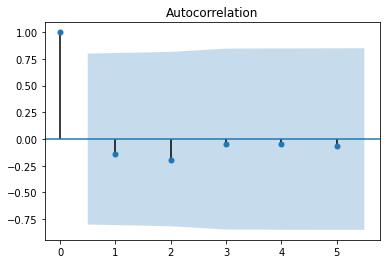

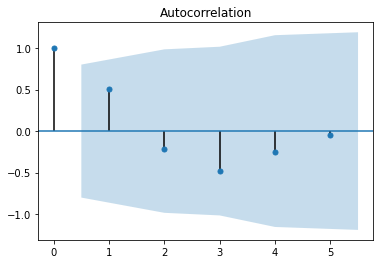

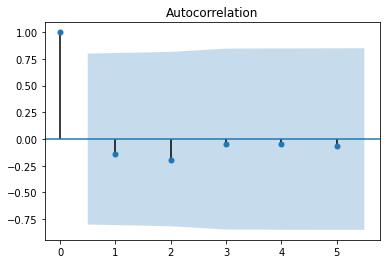

In [19]:
# Plotting the test data with auto correlation
from statsmodels.graphics.tsaplots import plot_acf
# The next 6 periods of mean temperature (graph 1) and wind_speed (graph 2)
plot_acf(df_forecast["meantemp"])
plot_acf(df_forecast["wind_speed"])

In [20]:
# Import Granger Causality module from the statsmodels package and use the Chi-Squared test metric
from statsmodels.tsa.stattools import grangercausalitytests
test_var = time_series.columns
lag_max = 12
test_type = 'ssr_chi2test'

causal_val = DataFrame(np.zeros((len(test_var),len(test_var))),columns=test_var,index=test_var)
for a in test_var:
    for b in test_var:
        c = grangercausalitytests ( time_series [ [b,a] ], maxlag = lag_max, verbose = False)
        pred_val = [round ( c [ i +1 ] [0] [test_type] [1], 5 ) for i in range (lag_max) ]
        min_value = np.min (pred_val)
        causal_val.loc[b,a] = min_value
causal_val

,meantemp,humidity,wind_speed,meanpressure
meantemp,1.00000,0.00382,0.00054,0.22012
humidity,0.00000,1.00000,0.13319,0.15053
wind_speed,0.00000,0.00000,1.00000,0.52294
meanpressure,0.00633,0.43641,0.04252,1.00000
